This example code shows the LeNet model execution:
1. Accelerators
2. Transforms

In [2]:
#libs
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
torch.use_deterministic_algorithms(True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Currently using {device} device")

Currently using cpu device


If there is a need to use accelerators then use the below code:

#device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

Updated one:

import torch
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()    #initalize nn.module
        # 3 input image channel, 6 output feature maps and 5x5 conv kernel
        self.cn1 = nn.Conv2d(3, 6, 5)
        # 6 input image channel, 16 output feature maps and 5x5 conv kernel
        self.cn2 = nn.Conv2d(6, 16, 5)
        # fully connected layers of size 120, 84 and 10
        #5*5 is the spatial dimension at this layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    
    def forward(self, x):
        # Convolution with 5x5 kernel
        x = F.relu(self.cn1(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        #print(f"After cn1 and max pool: {x.shape}")
        
        # Convolution with 5x5 kernel
        x = F.relu(self.cn2(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        #print(f"After cn2 and max pool: {x.shape}")
        
        # Flatten spatial and depth dimensions 
        # into a single vector
        x = x.view(-1, self.flattened_features(x))
        #print(f"After Flatterning: {x.shape}")
        
        # Fully connected operations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
    def flattened_features(self, x):
        # all except the first (batch) dimension
        size = x.size()[1:]  
        num_feats = 1
        for s in size:
            num_feats *= s
            #print(f" Number of features: {num_feats}")
        return num_feats


lenet = LeNet().to(device)   #prints nn model to device
print(lenet)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
def train(net, trainloader, optim, epoch):
    # initialize loss
    loss_total = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # ip refers to the input images, and 
        # ground_truth refers to the output classes the images belong to
        ip, ground_truth = data
        # zero the parameter gradients
        optim.zero_grad()
        # forward-pass + backward-pass + optimization -step
        op = net(ip)
        loss = nn.CrossEntropyLoss()(op, ground_truth)
        loss.backward()
        optim.step()
        # update loss
        loss_total += loss.item()
        # print loss statistics
        if (i+1) % 1000 == 0:
            # print at the interval of 1000 mini-batches
            print('[Epoch number : %d, Mini-batches: %5d] \
                  loss: %.3f' % (epoch + 1, i + 1, 
                                 loss_total / 200))
            loss_total = 0.0

In [6]:
def test(net, testloader):
    success = 0
    counter = 0
    with torch.no_grad():
        for data in testloader:
            im, ground_truth = data
            op = net(im)
            _, pred = torch.max(op.data, 1)
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()
    print('LeNet accuracy on 10000 images from test dataset: %d %%'\
        % (100 * success / counter))

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13999999..1.1933334].


Image batch dimensions: torch.Size([4, 3, 128, 128])
Image label dimensions: torch.Size([4])
Image batch dimensions: torch.Size([4, 3, 128, 128])
Image label dimensions: torch.Size([4])


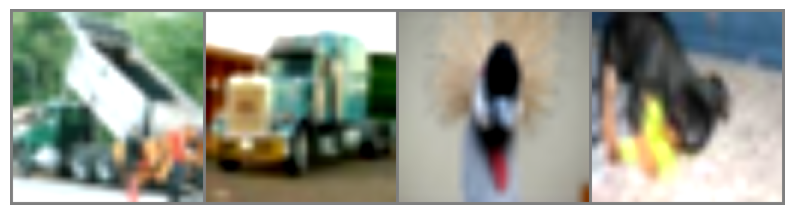

    truck  |  truck  |  bird  |  dog


In [7]:
# The mean and std are kept as 0.5 for normalizing 
# pixel values as the pixel values are originally 
# in the range 0 to 1
#train_transform = transforms.Compose(
#    [transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32, 4),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), 
#                          (0.5, 0.5, 0.5))])
import os
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Ensure duplicate library loading is handled for specific systems
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.2),
     transforms.Resize(128),
     transforms.Normalize((0.48, 0.48, 0.48), 
                          (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', 
    train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, 
    batch_size=4, shuffle=True)
test_transform = transforms.Compose([transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), 
                         (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', 
    train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, 
    batch_size=10000, shuffle=False)

# ordering is important
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 
           'frog', 'horse', 'ship', 'truck')

for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

# Checking the dataset
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Helper function to display images
def imshow(img):
    img = img / 1.5 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print class labels
#print(' '.join(f'{classes[labels[j]]}' for j in range(4)))
num_images = 4
print('    '+'  |  '.join(classes[labels[j]] 
                           for j in range(num_images)))

This code shows sample images with the view of brightness, contrast, saturation, and hue:

Based on requreiment we can select the values

Files already downloaded and verified


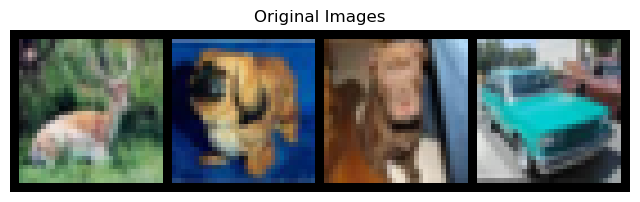

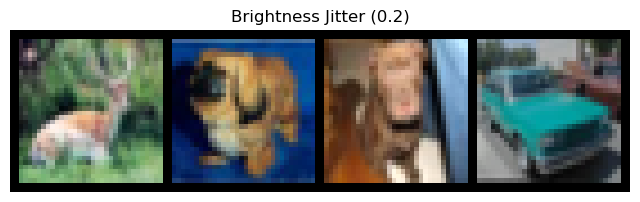

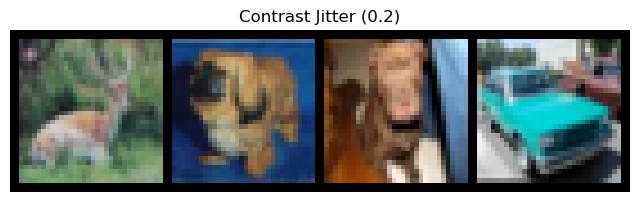

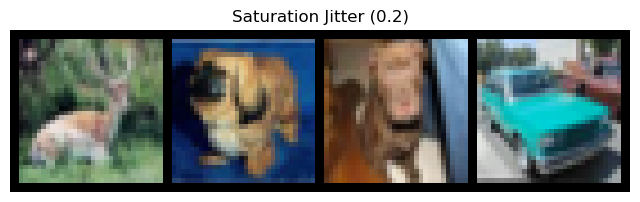

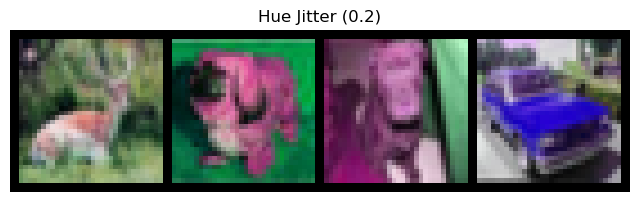

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
transform = transforms.ToTensor()
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2
)

# Get a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

def plot_jittered_images(images, jitter_transform, title):
    jittered_images = [jitter_transform(img) for img in images]
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(torch.stack(jittered_images)).permute(1, 2, 0))
    plt.title(title)
    plt.show()

# Define individual transformations
brightness_jitter = transforms.ColorJitter(brightness=0.2)
contrast_jitter = transforms.ColorJitter(contrast=0.2)
saturation_jitter = transforms.ColorJitter(saturation=0.2)
hue_jitter = transforms.ColorJitter(hue=0.2)

# Plot original images
plot_jittered_images(images, jitter_transform=lambda x: x, title="Original Images")

# Plot transformations
plot_jittered_images(images, brightness_jitter, title="Brightness Jitter (0.2)")
plot_jittered_images(images, contrast_jitter, title="Contrast Jitter (0.2)")
plot_jittered_images(images, saturation_jitter, title="Saturation Jitter (0.2)")
plot_jittered_images(images, hue_jitter, title="Hue Jitter (0.2)")


Shows each step of cnn layers amd number of features, for this detailed version, taking only 3 epochs

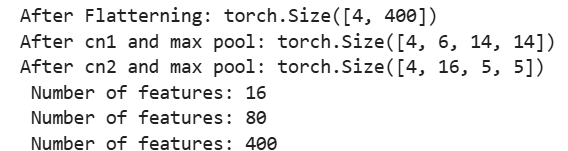

This image shows number of features

In [11]:
# define optimizer
optim = torch.optim.Adam(lenet.parameters(), lr=0.002)
# training loop over the dataset multiple times
for epoch in range(6):  
    train(lenet, trainloader, optim, epoch)
    print()
    test(lenet, testloader)
    print()
print('Finished Training')

[Epoch number : 1, Mini-batches:  1000]                   loss: 10.749
[Epoch number : 1, Mini-batches:  2000]                   loss: 10.079
[Epoch number : 1, Mini-batches:  3000]                   loss: 9.463
[Epoch number : 1, Mini-batches:  4000]                   loss: 9.308
[Epoch number : 1, Mini-batches:  5000]                   loss: 9.139
[Epoch number : 1, Mini-batches:  6000]                   loss: 9.026
[Epoch number : 1, Mini-batches:  7000]                   loss: 8.980
[Epoch number : 1, Mini-batches:  8000]                   loss: 8.765
[Epoch number : 1, Mini-batches:  9000]                   loss: 8.806
[Epoch number : 1, Mini-batches: 10000]                   loss: 8.737
[Epoch number : 1, Mini-batches: 11000]                   loss: 8.481
[Epoch number : 1, Mini-batches: 12000]                   loss: 8.492

LeNet accuracy on 10000 images from test dataset: 13 %

[Epoch number : 2, Mini-batches:  1000]                   loss: 8.437
[Epoch number : 2, Mini-batches

In [13]:
model_path = 'C:/Users/athma/Machine_Learning_Projects/lenet_cifar_model.pth'
torch.save(lenet.state_dict(), model_path)

In [14]:
# Load the trained model
model_path = 'C:/Users/athma/Machine_Learning_Projects/lenet_cifar_model.pth'
lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))
lenet_cached.eval()

# Class labels for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model evaluation
success = 0
counter = 0
with torch.no_grad():
    for im, ground_truth in testloader:
        op = lenet_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

accuracy = 100 * success / counter
print(f'Model accuracy on 10,000 images from test dataset: {accuracy:.2f}%')

C:\Users\athma\AppData\Local\Temp\ipykernel_27772\3923900795.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_cached.load_state_dict(torch.load(model_path))


Model accuracy on 10,000 images from test dataset: 14.68%


In [15]:
# Initialize lists for all 10 classes
class_sucess = [0.0 for _ in range(10)]
class_counter = [0.0 for _ in range(10)]

with torch.no_grad():
    for im, ground_truth in testloader:
        op = lenet_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()

        # Iterate over the current batch
        for i in range(len(ground_truth)):
            ground_truth_curr = ground_truth[i].item()  # Ensure it's an integer
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1

# Accuracy per class
for i in range(10):
    if class_counter[i] > 0:
        accuracy = 100 * class_sucess[i] / class_counter[i]
        print(f'Model accuracy for class {classes[i]:5s} : {accuracy:.2f}%')
    else:
        print(f'Model accuracy for class {classes[i]:5s} : No samples')


Model accuracy for class plane : 31.20%
Model accuracy for class car   : 17.70%
Model accuracy for class bird  : 3.80%
Model accuracy for class cat   : 0.70%
Model accuracy for class deer  : 2.00%
Model accuracy for class dog   : 1.70%
Model accuracy for class frog  : 2.40%
Model accuracy for class horse : 4.60%
Model accuracy for class ship  : 75.50%
Model accuracy for class truck : 7.20%
